In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table

# Map Measurement class
Measurement = Base.classes.measurement

# Map Station class
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Inspect Tables
inspector = inspect(engine)

In [10]:
# Get a list of column names and types for Measurement Table
columns = inspector.get_columns('Measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Get a list of column names and types for Station Table
columns = inspector.get_columns('Station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Find the most recent date in the data set.
mosrec_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
mosrec_date

('2017-08-23',)

In [13]:
### Design a query to retrieve the last 12 months of precipitation data and plot the results. 
### Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
prev_year = dt.datetime.strptime(mosrec_date[0], "%Y-%m-%d") - dt.timedelta(days=365)
print(prev_year)

2016-08-23 00:00:00


In [14]:
# Perform a query to retrieve the date and precipitation scores
prevyear_prcp = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= '2016-08-23').all()

# Save the query results as a Pandas DataFrame
prcp_df = pd.DataFrame(prevyear_prcp, columns=['date', 'precipitation'])

# # Change date type to datetime object on Pandas and set the index to the date column
prcp_df['date'] = pd.to_datetime(prcp_df['date'], format='%Y-%m-%d')
prcp_df.set_index('date', inplace=True)

# Sort the dataframe by date
prcp_df.sort_values('date', ascending=True)

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


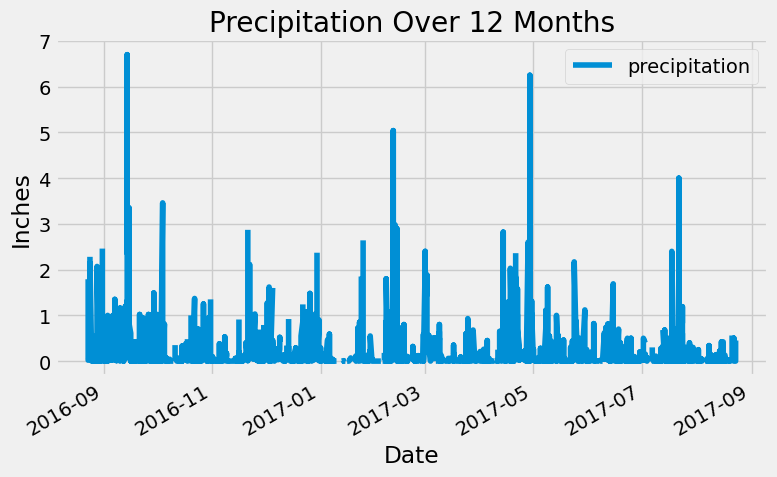

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(figsize=(8,5))

# Provide title, labels and formatting
plt.title('Precipitation Over 12 Months')
plt.ylabel('Inches')
plt.xlabel('Date')
plt.tight_layout()
plt.legend(loc='upper right')

# Save line graph to folder
plt.savefig('../Images/precipitation.png')

# Show line graph
plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
station_total = session.query(Measurement.station).distinct().count()
station_total

9

In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
station_activity = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()

# List the stations and the counts in descending order.
print(f'Stations in order of Activity:')
station_activity

Stations in order of Activity:


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
mosact_station = station_activity[0][0]

# Create list of query functions
sel = [func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

# query the table by unpacking list and filtering for most active station (USC00519281)
mas_temps = session.query(*sel).\
    filter(Measurement.station == mosact_station).all()

# Print the station's results
print(f'Temperature Readings for Most Active Station ({mosact_station}):')
print(f'Low: {mas_temps[0][0]}   High: {mas_temps[0][1]}   Average: {mas_temps[0][2]}')

Temperature Readings for Most Active Station (USC00519281):
Low: 54.0   High: 85.0   Average: 71.66378066378067


In [20]:
# Using the most active station id, query the last 12 months of temperature observation data for this station
mas_tobs = session.query(Measurement.tobs).\
    filter(Measurement.station == mosact_station).\
    filter(Measurement.date >= '2016-08-23').all()

# Save the query results as a Pandas DataFrame
mas_tobs_df = pd.DataFrame(mas_tobs, columns=['tobs'])

<function matplotlib.pyplot.show(close=None, block=None)>

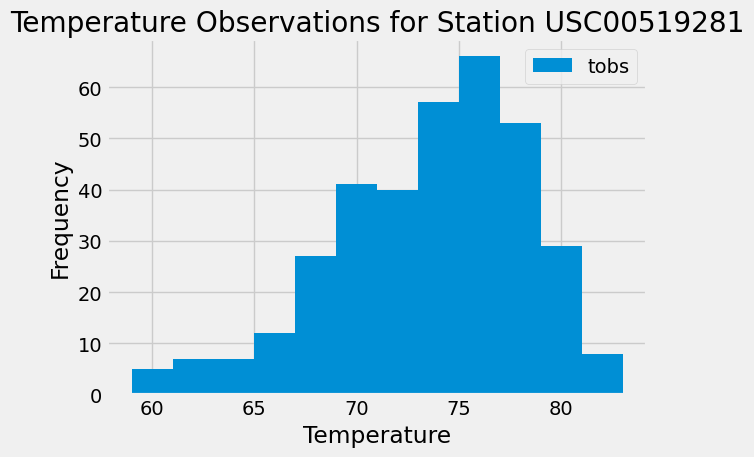

In [21]:
# Plot the query results as a histogram using 'bins=12'
mas_tobs_df.plot.hist(bins=12)

# Provide title, labels and formatting
plt.title('Temperature Observations for Station ' + mosact_station)
plt.xlabel('Temperature')
plt.tight_layout()

# Save histogram to folder
plt.savefig('../Images/tempvsfreq.png')

# Show histogram
plt.show

# Close session

In [22]:
# Close Session
session.close()